In [22]:
# ============================================================
# Cell 1: Import Libraries
# ============================================================
import sys
sys.path.append('..')  # Add parent directory to import our modules

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Our project modules
from models.model import build_efficientnet_b0
from src.utils import load_checkpoint, get_device

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {get_device()}")

PyTorch version: 2.9.1+cpu
Device: cpu


## 1️⃣ Dataset Exploration

**CIFAR-10** is a classic benchmark dataset:
- 60,000 color images (32×32 pixels)
- 10 classes, 6,000 images per class
- Train: 50,000 | Test: 10,000

In [23]:
# ============================================================
# Cell 2: Load CIFAR-10 and Define Class Names
# ============================================================

# CIFAR-10 class names (in order of label index 0-9)
CLASS_NAMES = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Load raw dataset (no transforms) for visualization
raw_dataset = datasets.CIFAR10(root='../data', train=False, download=True)

print(f"Dataset size: {len(raw_dataset)} images")
print(f"Image shape: {np.array(raw_dataset[0][0]).shape}")
print(f"Classes: {CLASS_NAMES}")

Dataset size: 10000 images
Image shape: (32, 32, 3)
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


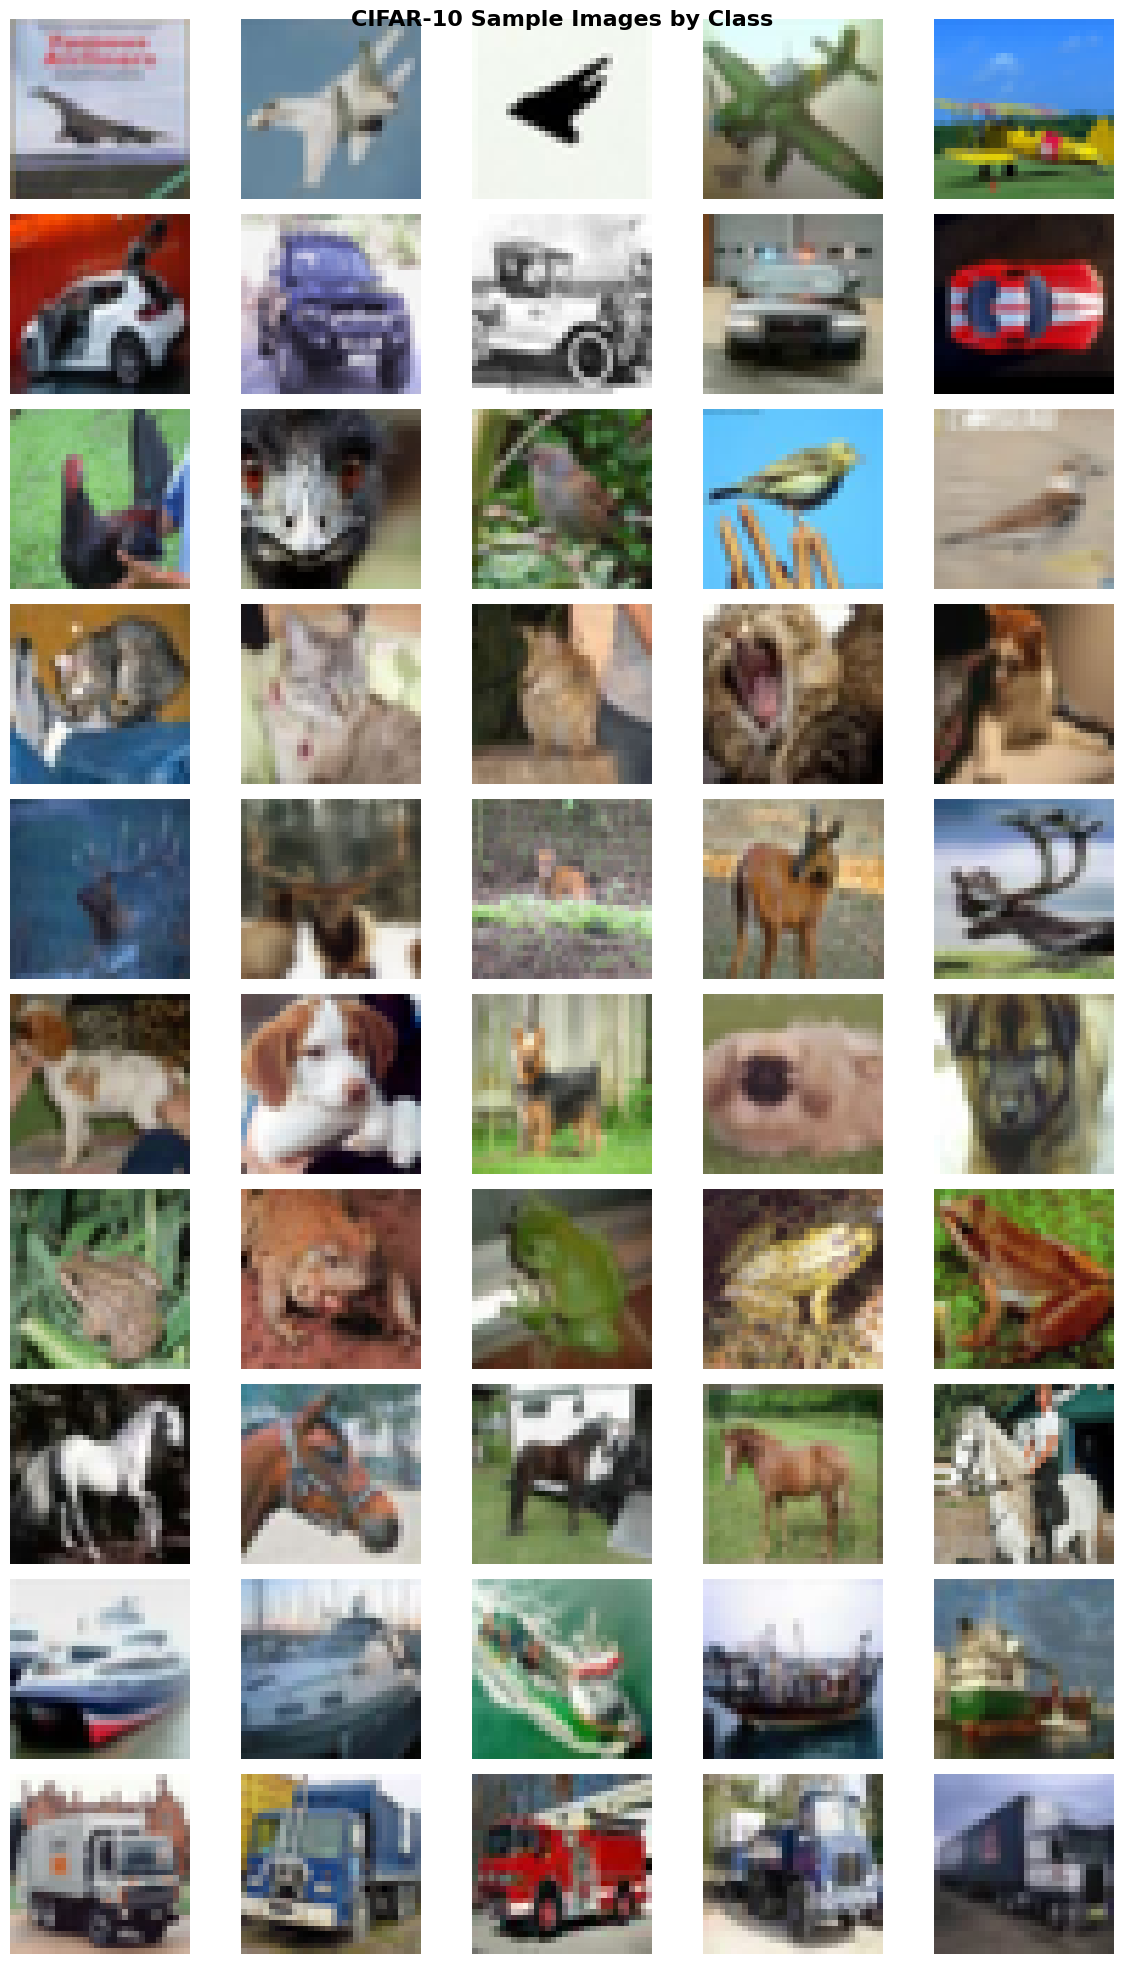

In [24]:
# ============================================================
# Cell 3: Visualize Sample Images per Class
# ============================================================

def plot_samples_per_class(dataset, class_names, samples_per_class=5):
    """
    Display a grid of sample images from each class.
    Helps understand what the model is trying to classify.
    """
    fig, axes = plt.subplots(len(class_names), samples_per_class, figsize=(12, 20))
    fig.suptitle('CIFAR-10 Sample Images by Class', fontsize=16, fontweight='bold')
    
    # Collect indices for each class
    class_indices = {i: [] for i in range(len(class_names))}
    for idx, (_, label) in enumerate(dataset):
        if len(class_indices[label]) < samples_per_class:
            class_indices[label].append(idx)
    
    # Plot samples
    for class_idx, class_name in enumerate(class_names):
        for sample_idx, data_idx in enumerate(class_indices[class_idx]):
            img, _ = dataset[data_idx]
            axes[class_idx, sample_idx].imshow(img)
            axes[class_idx, sample_idx].axis('off')
            if sample_idx == 0:
                axes[class_idx, sample_idx].set_ylabel(class_name, fontsize=12, rotation=0, 
                                                       labelpad=50, va='center')
    
    plt.tight_layout()
    plt.show()

plot_samples_per_class(raw_dataset, CLASS_NAMES)

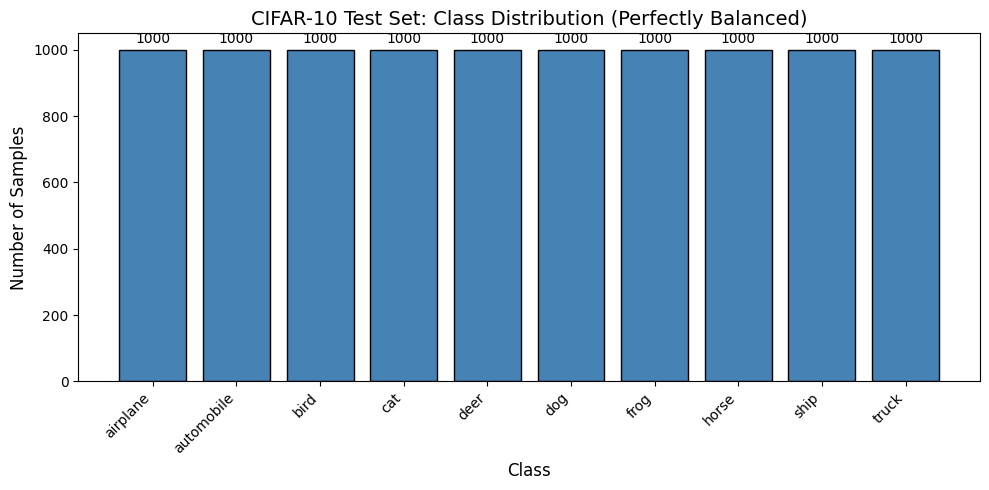

✓ Dataset is perfectly balanced - no class imbalance issues!


In [25]:
# ============================================================
# Cell 4: Class Distribution (Bar Plot)
# ============================================================

# Count samples per class
labels = [label for _, label in raw_dataset]
unique, counts = np.unique(labels, return_counts=True)

# Plot distribution
plt.figure(figsize=(10, 5))
bars = plt.bar(CLASS_NAMES, counts, color='steelblue', edgecolor='black')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('CIFAR-10 Test Set: Class Distribution (Perfectly Balanced)', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Add count labels on bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
             str(count), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print("✓ Dataset is perfectly balanced - no class imbalance issues!")

## 2️⃣ Load Trained Model

Load the checkpoint saved during training to evaluate performance.

In [ ]:
# ============================================================
# Cell 5: Load Trained Model from Checkpoint
# ============================================================

MODEL_PATH = '../models/efficientnet_cifar10_best.pth'
device = get_device()

# Build model architecture
model = build_efficientnet_b0(num_classes=10, pretrained=False)

# Load trained weights
try:
    ckpt = load_checkpoint(MODEL_PATH, map_location=device)
    model.load_state_dict(ckpt['model_state'])
    print(f"✓ Model loaded successfully!")
    print(f"  - Trained for {ckpt.get('epoch', 'N/A')} epochs")
    print(f"  - Best validation accuracy: {ckpt.get('best_val_acc', 'N/A'):.4f}")
except FileNotFoundError:
    print(f"⚠ Model not found at {MODEL_PATH}")
    print("  Run training first or download from Colab")

✓ Checkpoint loaded successfully!
  - Trained for 5 epochs
  - Best validation accuracy: 0.9731

Model loaded on: cpu


## 3️⃣ Confusion Matrix Analysis

The confusion matrix shows:
- **Diagonal**: Correct predictions (we want high values here)
- **Off-diagonal**: Misclassifications (which classes get confused)

In [27]:
# ============================================================
# Cell 6: Prepare Test DataLoader
# ============================================================

# Same transforms used during training (ImageNet normalization)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # EfficientNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), 
                        std=(0.229, 0.224, 0.225))
])

test_dataset = datasets.CIFAR10(
    root='../data', train=False, download=True, transform=test_transforms
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=0
)

print(f"Test batches: {len(test_loader)}")

Test batches: 157


In [28]:
# ============================================================
# Cell 7: Generate Predictions for Entire Test Set
# ============================================================

@torch.no_grad()
def get_all_predictions(model, loader, device):
    """Run inference on entire dataset, return predictions and labels."""
    all_preds = []
    all_labels = []
    all_probs = []
    
    for images, labels in loader:
        images = images.to(device)
        logits = model(images)
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

print("Running inference on test set...")
predictions, true_labels, probabilities = get_all_predictions(model, test_loader, device)

accuracy = (predictions == true_labels).mean()
print(f"\n✓ Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

Running inference on test set...

✓ Test Accuracy: 0.9733 (97.33%)


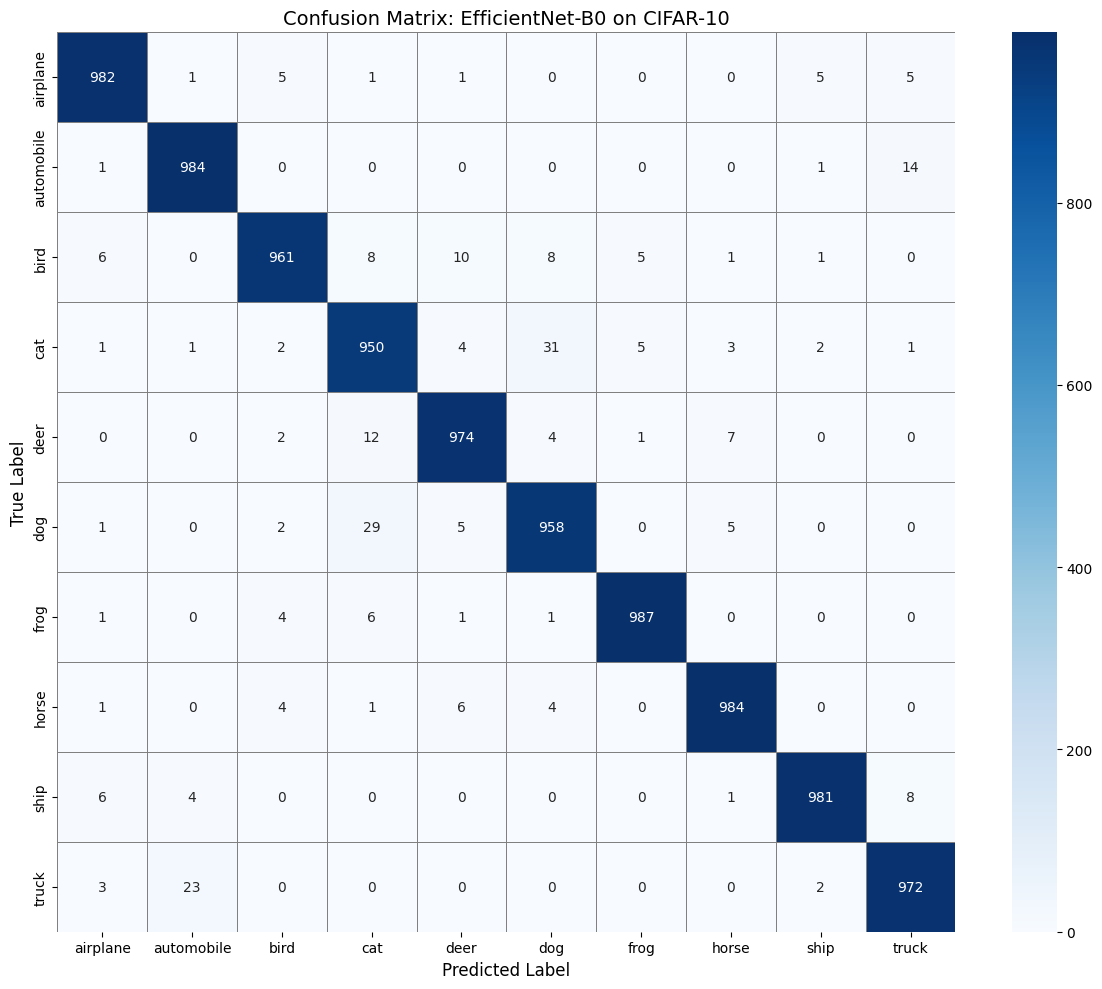

In [29]:
# ============================================================
# Cell 8: Plot Confusion Matrix
# ============================================================

def plot_confusion_matrix(y_true, y_pred, class_names):
    """Generate and display a beautiful confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                linewidths=0.5, linecolor='gray')
    
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title('Confusion Matrix: EfficientNet-B0 on CIFAR-10', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return cm

cm = plot_confusion_matrix(true_labels, predictions, CLASS_NAMES)

In [30]:
# ============================================================
# Cell 9: Classification Report (Precision, Recall, F1)
# ============================================================

print("="*60)
print("Classification Report")
print("="*60)
print(classification_report(true_labels, predictions, target_names=CLASS_NAMES))

Classification Report
              precision    recall  f1-score   support

    airplane       0.98      0.98      0.98      1000
  automobile       0.97      0.98      0.98      1000
        bird       0.98      0.96      0.97      1000
         cat       0.94      0.95      0.95      1000
        deer       0.97      0.97      0.97      1000
         dog       0.95      0.96      0.96      1000
        frog       0.99      0.99      0.99      1000
       horse       0.98      0.98      0.98      1000
        ship       0.99      0.98      0.98      1000
       truck       0.97      0.97      0.97      1000

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



## 4️⃣ Grad-CAM Visualization

**Grad-CAM** (Gradient-weighted Class Activation Mapping) shows which regions of the image the model focuses on to make its prediction.

- 🔴 **Red/Yellow**: High importance regions
- 🔵 **Blue**: Low importance regions

In [31]:
# ============================================================
# Cell 10: Grad-CAM Implementation
# ============================================================

class GradCAM:
    """
    Grad-CAM implementation for EfficientNet.
    
    How it works:
    1. Hook into the last convolutional layer to capture activations
    2. Compute gradients of the target class w.r.t. these activations
    3. Weight activations by average gradient (importance)
    4. Generate heatmap highlighting important regions
    """
    
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.activations = None
        
        # Hook into the last conv layer of EfficientNet (features[-1])
        self.target_layer = model.features[-1]
        self.target_layer.register_forward_hook(self._save_activation)
        self.target_layer.register_full_backward_hook(self._save_gradient)
    
    def _save_activation(self, module, input, output):
        self.activations = output.detach()
    
    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def generate_cam(self, input_tensor, target_class=None):
        """
        Generate Grad-CAM heatmap for an input image.
        
        Args:
            input_tensor: Preprocessed image tensor (1, 3, H, W)
            target_class: Class to visualize (None = predicted class)
        
        Returns:
            cam: Normalized heatmap (H, W)
            pred_class: Predicted class index
        """
        self.model.eval()
        
        # Forward pass
        output = self.model(input_tensor)
        pred_class = output.argmax(dim=1).item()
        
        if target_class is None:
            target_class = pred_class
        
        # Backward pass for target class
        self.model.zero_grad()
        output[0, target_class].backward()
        
        # Compute weights (global average pooling of gradients)
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)  # (1, C, 1, 1)
        
        # Weighted combination of activations
        cam = (weights * self.activations).sum(dim=1, keepdim=True)  # (1, 1, H, W)
        cam = F.relu(cam)  # Only positive contributions
        
        # Resize to input size and normalize
        cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)  # Normalize to [0, 1]
        
        return cam, pred_class

# Initialize Grad-CAM
grad_cam = GradCAM(model)
print("✓ Grad-CAM initialized")

✓ Grad-CAM initialized


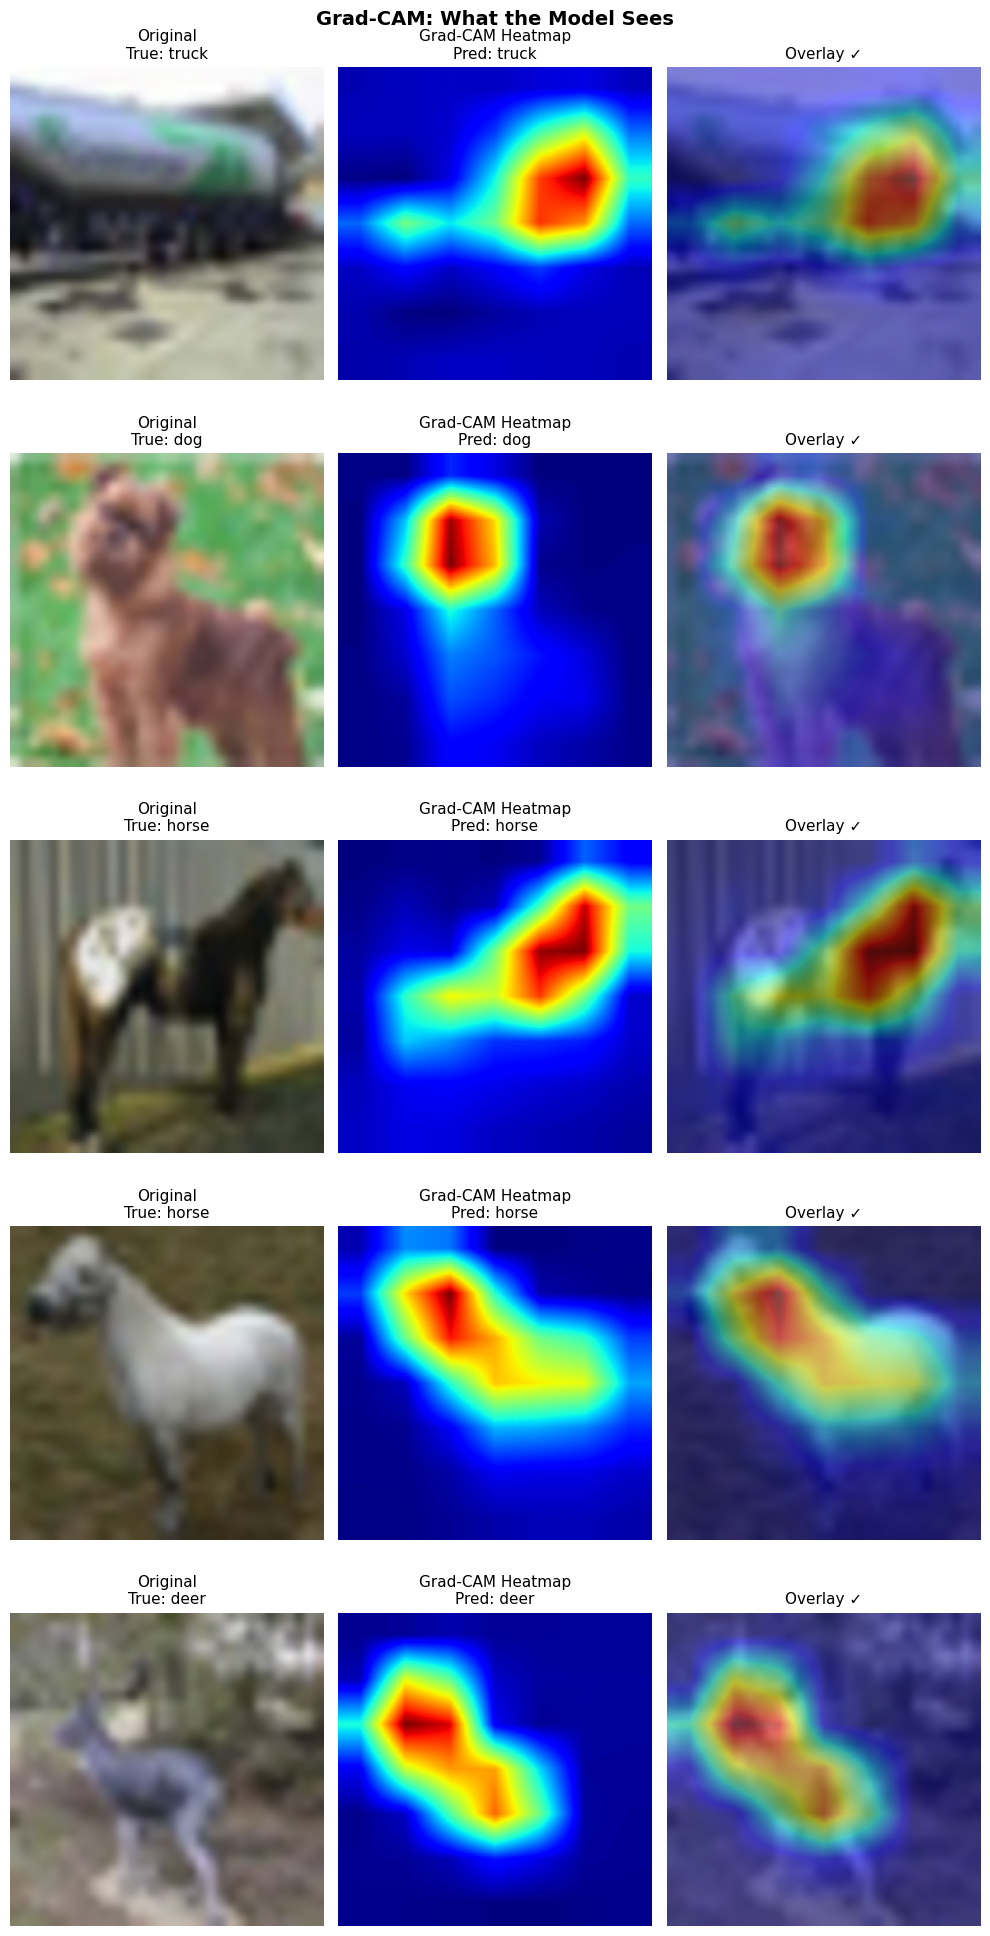

In [32]:
# ============================================================
# Cell 11: Visualize Grad-CAM on Sample Images
# ============================================================

def visualize_gradcam(model, grad_cam, dataset, raw_dataset, indices, class_names, device):
    """
    Display original images alongside their Grad-CAM heatmaps.
    """
    n_samples = len(indices)
    fig, axes = plt.subplots(n_samples, 3, figsize=(10, 4*n_samples))
    
    if n_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i, idx in enumerate(indices):
        # Get preprocessed and raw images
        img_tensor, true_label = dataset[idx]
        raw_img, _ = raw_dataset[idx]
        
        # Generate Grad-CAM
        input_tensor = img_tensor.unsqueeze(0).to(device)
        cam, pred_class = grad_cam.generate_cam(input_tensor)
        
        # Resize raw image to match CAM
        raw_img_resized = raw_img.resize((224, 224))
        raw_img_array = np.array(raw_img_resized) / 255.0
        
        # Plot original image
        axes[i, 0].imshow(raw_img_resized)
        axes[i, 0].set_title(f'Original\nTrue: {class_names[true_label]}', fontsize=11)
        axes[i, 0].axis('off')
        
        # Plot Grad-CAM heatmap
        axes[i, 1].imshow(cam, cmap='jet')
        axes[i, 1].set_title(f'Grad-CAM Heatmap\nPred: {class_names[pred_class]}', fontsize=11)
        axes[i, 1].axis('off')
        
        # Plot overlay
        heatmap = plt.cm.jet(cam)[:, :, :3]  # Convert to RGB
        overlay = 0.5 * raw_img_array + 0.5 * heatmap
        axes[i, 2].imshow(overlay)
        status = "✓" if pred_class == true_label else "✗"
        axes[i, 2].set_title(f'Overlay {status}', fontsize=11)
        axes[i, 2].axis('off')
    
    plt.suptitle('Grad-CAM: What the Model Sees', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualize random samples
sample_indices = np.random.choice(len(test_dataset), 5, replace=False)
visualize_gradcam(model, grad_cam, test_dataset, raw_dataset, sample_indices, CLASS_NAMES, device)

## 5️⃣ Error Analysis

Let's examine images that the model **misclassified** to understand its weaknesses.

Total misclassified: 267 / 10000
Error rate: 2.67%

Visualizing misclassified samples with Grad-CAM:


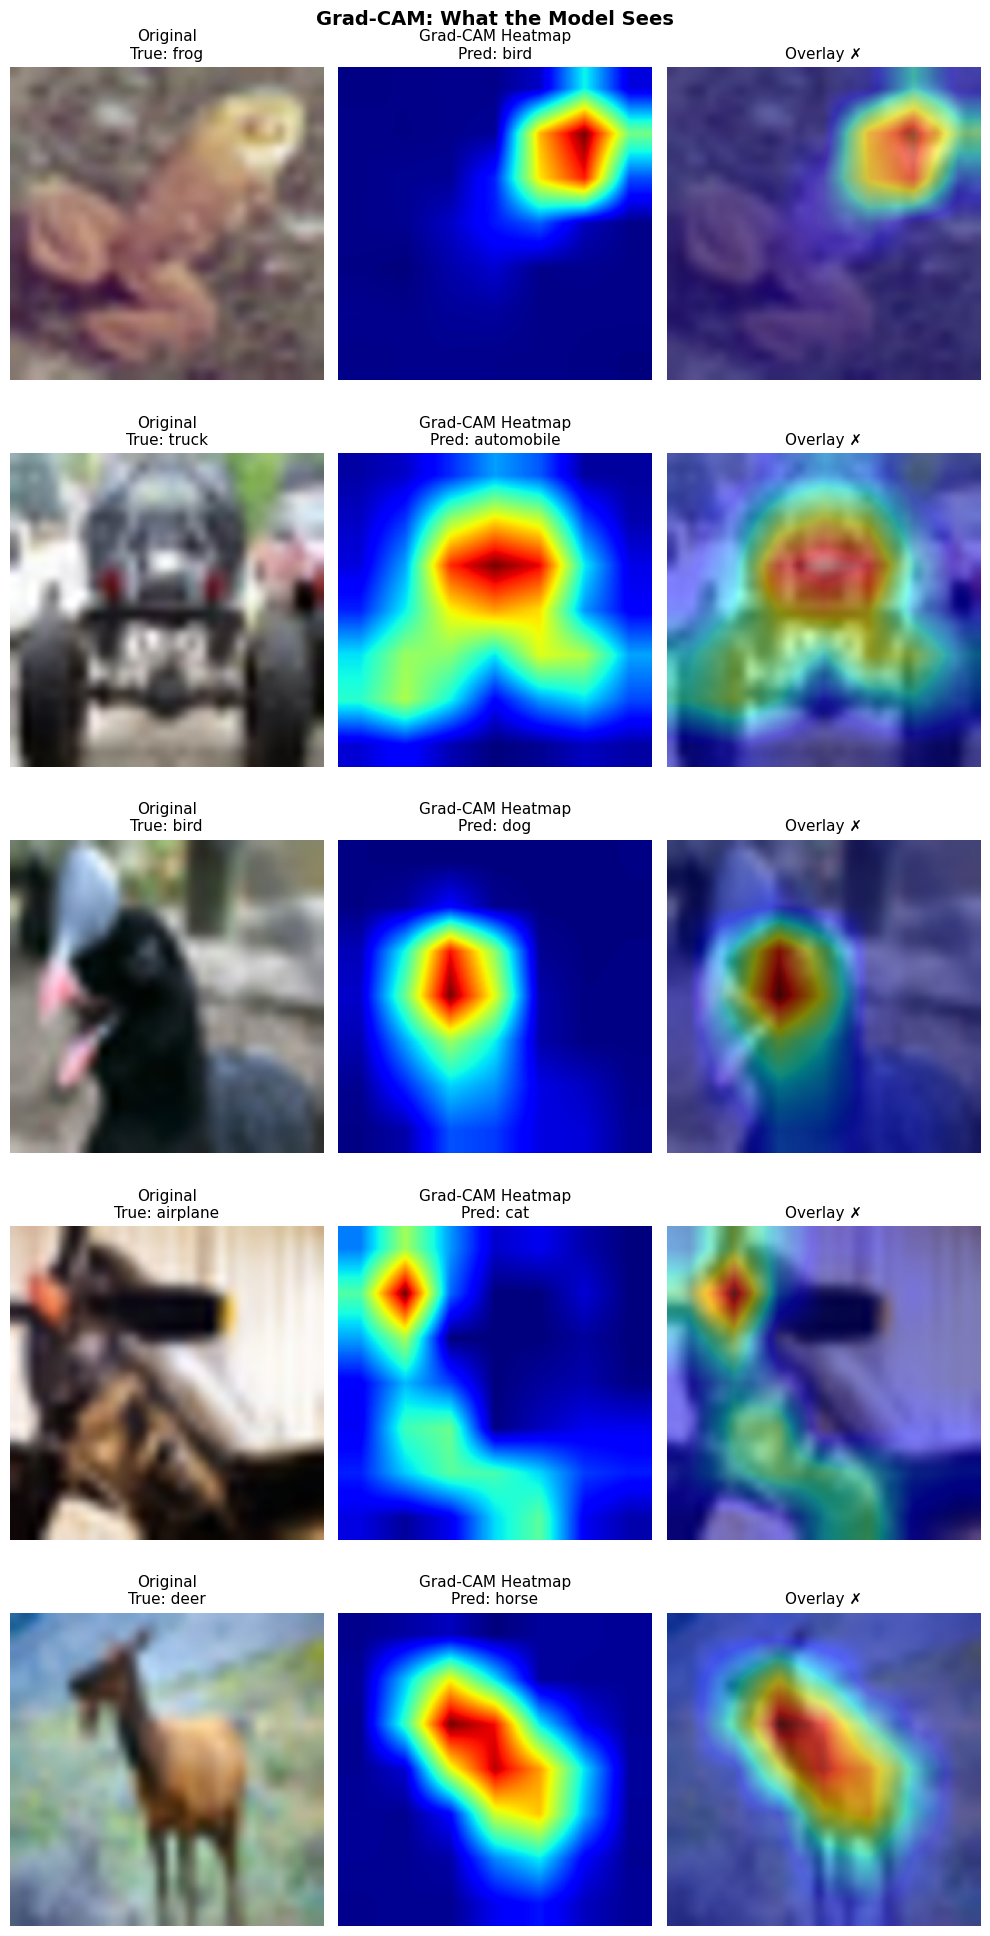

In [33]:
# ============================================================
# Cell 12: Find and Visualize Misclassified Images
# ============================================================

# Find misclassified samples
misclassified_indices = np.where(predictions != true_labels)[0]
print(f"Total misclassified: {len(misclassified_indices)} / {len(true_labels)}")
print(f"Error rate: {len(misclassified_indices)/len(true_labels)*100:.2f}%\n")

# Show some misclassified examples with Grad-CAM
if len(misclassified_indices) > 0:
    sample_errors = np.random.choice(misclassified_indices, min(5, len(misclassified_indices)), replace=False)
    print("Visualizing misclassified samples with Grad-CAM:")
    visualize_gradcam(model, grad_cam, test_dataset, raw_dataset, sample_errors, CLASS_NAMES, device)
else:
    print("🎉 No misclassifications! Model achieved 100% accuracy.")

In [34]:
# ============================================================
# Cell 13: Most Confused Class Pairs
# ============================================================

def find_most_confused_pairs(cm, class_names, top_k=5):
    """Find class pairs that are most frequently confused."""
    # Zero out diagonal (correct predictions)
    cm_no_diag = cm.copy()
    np.fill_diagonal(cm_no_diag, 0)
    
    # Find top confused pairs
    confused_pairs = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm_no_diag[i, j] > 0:
                confused_pairs.append((class_names[i], class_names[j], cm_no_diag[i, j]))
    
    # Sort by confusion count
    confused_pairs.sort(key=lambda x: x[2], reverse=True)
    
    return confused_pairs[:top_k]

print("Most Confused Class Pairs:")
print("="*50)
confused = find_most_confused_pairs(cm, CLASS_NAMES)
for true_class, pred_class, count in confused:
    print(f"  {true_class:12} → {pred_class:12} : {int(count)} errors")

print("\n💡 These confusions often make sense semantically!")
print("   e.g., cat↔dog, automobile↔truck are visually similar")

Most Confused Class Pairs:
  cat          → dog          : 31 errors
  dog          → cat          : 29 errors
  truck        → automobile   : 23 errors
  automobile   → truck        : 14 errors
  deer         → cat          : 12 errors

💡 These confusions often make sense semantically!
   e.g., cat↔dog, automobile↔truck are visually similar


## 📝 Summary

### Key Findings

1. **Dataset**: CIFAR-10 is perfectly balanced (1000 samples/class in test set)

2. **Model Performance**: Check confusion matrix for per-class accuracy

3. **Common Confusions**: Typically between visually similar classes (cat/dog, car/truck)

4. **Grad-CAM Insights**: Model learns to focus on discriminative features (eyes, wheels, wings)

### Next Steps
- Try fine-tuning the backbone (remove `--freeze-backbone`)
- Experiment with data augmentation
- Try EfficientNet-B1/B2 for potentially higher accuracy